# MNIST

In [1]:
import copy
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Define a transformation to normalize pixel values to a range between -1 and 1
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root="../", train=True, transform=transform, download=False)
test_dataset = datasets.MNIST(root="../", train=False, transform=transform, download=False)

# Create data loaders for batching and shuffling
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Set a random seed for reproducibility
torch.manual_seed(42)

targets = torch.cat([y for x, y in test_loader], dim=0).numpy()

In [4]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def update_layers(self, new_layers):
        for i, new_layer in enumerate(new_layers):
            if hasattr(self, f'fc{i + 1}'):
                setattr(self, f'fc{i + 1}', new_layer)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [5]:
def train(model, train_loader, criterion, optimizer, epochs=10, device=device):
    for epoch in range(epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item()}")

In [6]:
model = MLP().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 10

train(model, train_loader, criterion, optimizer, epochs, device)

Epoch 1/10, Batch 0/938, Loss: 2.2986912727355957
Epoch 1/10, Batch 100/938, Loss: 0.536418080329895
Epoch 1/10, Batch 200/938, Loss: 0.24840493500232697
Epoch 1/10, Batch 300/938, Loss: 0.3447805643081665
Epoch 1/10, Batch 400/938, Loss: 0.30978962779045105
Epoch 1/10, Batch 500/938, Loss: 0.32436466217041016
Epoch 1/10, Batch 600/938, Loss: 0.11708302795886993
Epoch 1/10, Batch 700/938, Loss: 0.2867242693901062
Epoch 1/10, Batch 800/938, Loss: 0.2118917554616928
Epoch 1/10, Batch 900/938, Loss: 0.15657038986682892
Epoch 2/10, Batch 0/938, Loss: 0.27718374133110046
Epoch 2/10, Batch 100/938, Loss: 0.15662340819835663
Epoch 2/10, Batch 200/938, Loss: 0.3485846519470215
Epoch 2/10, Batch 300/938, Loss: 0.25658610463142395
Epoch 2/10, Batch 400/938, Loss: 0.3115203380584717
Epoch 2/10, Batch 500/938, Loss: 0.1860094964504242
Epoch 2/10, Batch 600/938, Loss: 0.2925609350204468
Epoch 2/10, Batch 700/938, Loss: 0.23824694752693176
Epoch 2/10, Batch 800/938, Loss: 0.06290964782238007
Epoch 2

In [14]:
@torch.no_grad()
def predict(dataloader, model, laplace=False):
    py = []

    for x, _ in dataloader:
        if laplace:
            py.append(model(x))
        else:
            py.append(torch.softmax(model(x), dim=-1))

    return torch.cat(py).cpu().numpy()

In [8]:
# img, label = train_dataset[0]
# print(img.shape)
# plt.imshow(img.squeeze(), cmap="gray")
# plt.show()

# torch.softmax(model(img.unsqueeze(0).to(device)), dim=-1)

probs_mlp = predict(test_loader, model, laplace=False)
acc_laplace = (probs_mlp.argmax(-1) == targets).astype(float).mean()
print(acc_laplace)

0.9679


In [53]:
class FastTensorDataLoader:
    """
    Source: https://github.com/hcarlens/pytorch-tabular/blob/master/fast_tensor_data_loader.py
    and https://discuss.pytorch.org/t/dataloader-much-slower-than-manual-batching/27014/6
    """
    def __init__(self, *tensors, batch_size=32, shuffle=False):
        assert all(t.shape[0] == tensors[0].shape[0] for t in tensors)
        self.tensors = tensors
        self.dataset = tensors[0]

        self.dataset_len = self.tensors[0].shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Calculate # batches
        n_batches, remainder = divmod(self.dataset_len, self.batch_size)
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches

    def __iter__(self):
        if self.shuffle:
            r = torch.randperm(self.dataset_len)
            self.tensors = [t[r] for t in self.tensors]
        self.i = 0
        return self

    def __next__(self):
        if self.i >= self.dataset_len:
            raise StopIteration
        batch = tuple(t[self.i:self.i+self.batch_size] for t in self.tensors)
        self.i += self.batch_size
        return batch

    def __len__(self):
        return self.n_batches

class PermutedMnistGenerator():
    def __init__(self, data_path='./data', num_tasks=10, random_seed=0, download=False):
        self.data_path = data_path
        self.num_tasks = num_tasks
        self.random_seed = random_seed
        self.download = download
        self.out_dim = 10           # number of classes in the MNIST dataset
        self.in_dim = 784           # each image has 28x28 pixels
        self.task_id = 0            # initialize the current task id

    def next_task(self, batch_size=256, val_size=0):
        if self.task_id >= self.num_tasks:
            raise Exception('Number of tasks exceeded!')
        else:
            np.random.seed(self.task_id+self.random_seed)
            perm_inds = np.arange(self.in_dim)

            # First task is (unpermuted) MNIST, subsequent tasks are random permutations of pixels
            if self.task_id > 0:
                np.random.shuffle(perm_inds)

            # make image a tensor and permute pixel values
            tforms = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: x.view(-1)[perm_inds]),
            ])

            # load datasets
            train_set = datasets.MNIST(self.data_path, train=True,
                                       transform=tforms, download=self.download)
            val_test_set = datasets.MNIST(self.data_path, train=False,
                                          transform=tforms, download=self.download)

            # fast DataLoader for training
            Xys = [train_set[i] for i in range(len(train_set))]
            Xs = torch.stack([e[0] for e in Xys])
            ys = torch.stack([torch.tensor(e[1]) for e in Xys])
            train_loader = FastTensorDataLoader(Xs, ys, batch_size=batch_size, shuffle=True)
            val_loader, test_loader = val_test_split(val_test_set,
                                                     batch_size=batch_size,
                                                     val_size=val_size,
                                                     num_workers=0)

            # increment task counter
            self.task_id += 1

            if val_size > 0:
                return train_loader, val_loader, test_loader
            return train_loader, test_loader

# Laplace Full network

In [64]:
from laplace import Laplace

# create and train MAP model
def get_model():
    # torch.manual_seed(711)
    return torch.nn.Sequential(
        torch.nn.Flatten(), torch.nn.Linear(28*28, 128), torch.nn.ReLU(), torch.nn.Linear(128, 10)
    )

# la_model = get_model().to(device)
la_model = get_model()

# from laplace.utils import ModuleNameSubnetMask
# subnetwork_mask = ModuleNameSubnetMask(model, module_names=['layer.1', 'layer.3'])
# subnetwork_mask.select()
# subnetwork_indices = subnetwork_mask.indices

la = Laplace(la_model, 'classification', subset_of_weights='all', hessian_structure='all')
la.fit(train_loader)

In [65]:
optimizer = optim.Adam(la_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 10

train(la_model, train_loader, criterion, optimizer, epochs, device='cpu')

Epoch 1/10, Batch 0/938, Loss: 2.3524539470672607
Epoch 1/10, Batch 100/938, Loss: 0.37617847323417664
Epoch 1/10, Batch 200/938, Loss: 0.23701009154319763
Epoch 1/10, Batch 300/938, Loss: 0.26912984251976013
Epoch 1/10, Batch 400/938, Loss: 0.21315805613994598
Epoch 1/10, Batch 500/938, Loss: 0.24192744493484497
Epoch 1/10, Batch 600/938, Loss: 0.20942436158657074
Epoch 1/10, Batch 700/938, Loss: 0.190696120262146
Epoch 1/10, Batch 800/938, Loss: 0.2646137475967407
Epoch 1/10, Batch 900/938, Loss: 0.23756569623947144
Epoch 2/10, Batch 0/938, Loss: 0.2713465690612793
Epoch 2/10, Batch 100/938, Loss: 0.17463646829128265
Epoch 2/10, Batch 200/938, Loss: 0.14676672220230103
Epoch 2/10, Batch 300/938, Loss: 0.42484673857688904
Epoch 2/10, Batch 400/938, Loss: 0.08503503352403641
Epoch 2/10, Batch 500/938, Loss: 0.1797647327184677
Epoch 2/10, Batch 600/938, Loss: 0.08224215358495712
Epoch 2/10, Batch 700/938, Loss: 0.11223670840263367
Epoch 2/10, Batch 800/938, Loss: 0.1306297928094864
Epoc

In [66]:
probs_laplace = predict(test_loader, la_model, laplace=True)
acc_laplace = (probs_laplace.argmax(-1) == targets).astype(float).mean()
print(acc_laplace)

0.9701


d:\coding\LotteryTicketPruning\playTest\reliability_diag.py:177: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(new_ticks)


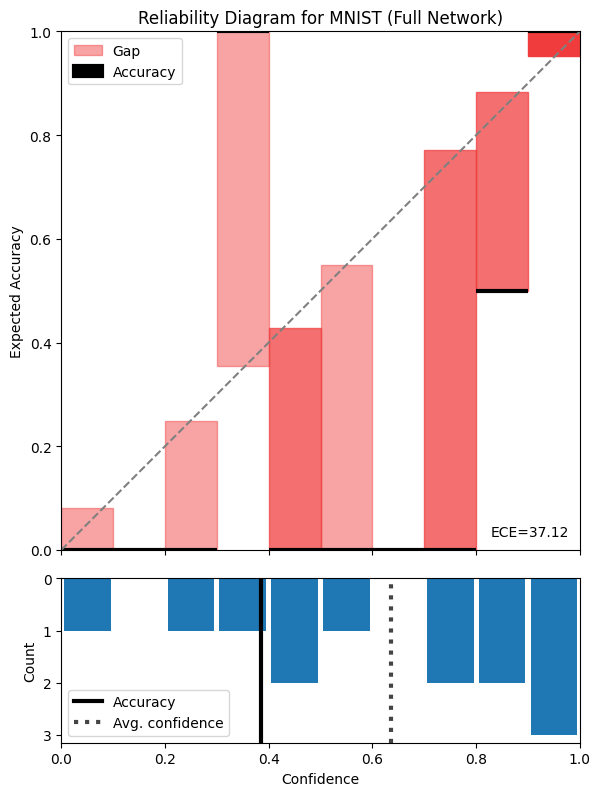

In [67]:
import reliability_diag as rd
import importlib
importlib.reload(rd)

title = "Reliability Diagram for MNIST (Full Network)"

fig = rd.reliability_diagram(
    targets.astype(float),
    probs_laplace.argmax(-1).astype(float),
    np.max(probs_laplace, axis=1).astype(float),
    num_bins=10, draw_ece=True,
    draw_bin_importance="alpha",
    draw_averages=True, title=title,
    figsize=(6, 6), 
    dpi=100, return_fig=True
    )

# Subnetwork: Last Layer

In [24]:
from laplace import Laplace

# create and train MAP model
def get_model():
    # torch.manual_seed(711)
    return torch.nn.Sequential(
        torch.nn.Flatten(), torch.nn.Linear(28*28, 128), torch.nn.ReLU(), torch.nn.Linear(128, 10)
    )

# la_model = get_model().to(device)
la_model = get_model()

# for name, param in la_model.named_parameters():
# 	print(name, param.shape)

from laplace.utils import ModuleNameSubnetMask
subnetwork_mask = ModuleNameSubnetMask(la_model, module_names=['3'])
subnetwork_mask.select()
subnetwork_indices = subnetwork_mask.indices

la = Laplace(la_model, 'classification', subset_of_weights='subnetwork', hessian_structure='full', subnetwork_indices=subnetwork_indices)
la.fit(train_loader)

1.weight torch.Size([128, 784])
1.bias torch.Size([128])
3.weight torch.Size([10, 128])
3.bias torch.Size([10])


In [25]:
optimizer = optim.Adam(la_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 10

train(la_model, train_loader, criterion, optimizer, epochs, device='cpu')

Epoch 1/10, Batch 0/938, Loss: 2.3160769939422607
Epoch 1/10, Batch 100/938, Loss: 0.5820902585983276
Epoch 1/10, Batch 200/938, Loss: 0.28578847646713257
Epoch 1/10, Batch 300/938, Loss: 0.24848727881908417
Epoch 1/10, Batch 400/938, Loss: 0.4475648105144501
Epoch 1/10, Batch 500/938, Loss: 0.2566995322704315
Epoch 1/10, Batch 600/938, Loss: 0.2432379126548767
Epoch 1/10, Batch 700/938, Loss: 0.5517505407333374
Epoch 1/10, Batch 800/938, Loss: 0.3190775215625763
Epoch 1/10, Batch 900/938, Loss: 0.22214767336845398
Epoch 2/10, Batch 0/938, Loss: 0.46998143196105957
Epoch 2/10, Batch 100/938, Loss: 0.21543151140213013
Epoch 2/10, Batch 200/938, Loss: 0.18171142041683197
Epoch 2/10, Batch 300/938, Loss: 0.28310054540634155
Epoch 2/10, Batch 400/938, Loss: 0.3337167203426361
Epoch 2/10, Batch 500/938, Loss: 0.19309040904045105
Epoch 2/10, Batch 600/938, Loss: 0.22307716310024261
Epoch 2/10, Batch 700/938, Loss: 0.10379878431558609
Epoch 2/10, Batch 800/938, Loss: 0.09056320041418076
Epoch

In [42]:
probs_laplace = predict(test_loader, la_model, laplace=True)
acc_laplace = (probs_laplace.argmax(-1) == targets).astype(float).mean()
print(acc_laplace)

0.9648


d:\coding\LotteryTicketPruning\playTest\reliability_diag.py:177: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(new_ticks)


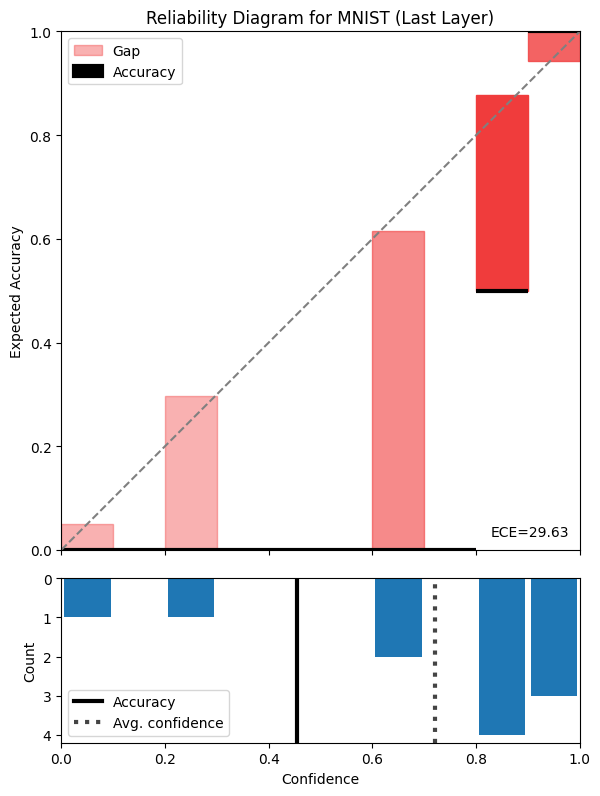

In [63]:
import reliability_diag as rd
import importlib
importlib.reload(rd)

title = "Reliability Diagram for MNIST (Last Layer)"

fig = rd.reliability_diagram(
    targets.astype(float),
    probs_laplace.argmax(-1).astype(float),
    np.max(probs_laplace, axis=1).astype(float),
    num_bins=10, draw_ece=True,
    draw_bin_importance="alpha",
    draw_averages=True, title=title,
    figsize=(6, 6), 
    dpi=100, return_fig=True
    )

In [54]:
np.max(probs_laplace, axis=1).astype(float)
# probs_laplace.argmax(-1).astype(float)

array([ 9.48554325, 11.09114456,  6.67536736, ..., 14.51783562,
       12.97873592, 14.2789917 ])

<module 'reliability_diag' from 'd:\\coding\\LotteryTicketPruning\\playTest\\reliability_diag.py'>